# US Stock Market Overview

In [24]:
# Imporintg libraries
import numpy as np
import pandas as pd
from scipy.stats import zscore

from IPython.display import Markdown as md
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [25]:
# Reading finviz data
path = './2021-02-10T20:36:29.csv'

In [26]:
df = pd.read_csv(path)
df = df.set_index('No.') # Set the index to No. column

In [27]:
# Replacing missing data with NaN
for col in df.columns:
    df[col].replace('-', np.nan, inplace=True)

# Change column: Data Cleaning
def changeCalc(row):
    return float(str(row['Change'])[:-1])
df['Change'] = df.apply(changeCalc, axis='columns')

# Volume column: Data Cleaning
def volCalc(row):
    return int(''.join(str(row.Volume).split(',')))
df['Volume'] = df.apply(volCalc, axis='columns')

# Market Cap: Data Cleaning
def capCalc(row):
    s = str(row['Market Cap']).strip()
    if s[-1] == 'M':
        return float(s[:-1])
    elif s[-1] == 'B':
        return float(s[:-1]) * 1000
df['Market Cap'] = df.apply(capCalc, axis='columns') # Notify that Market Cap is based on Million $.

# P/E column: Data Cleaning
def peCalc(row):
    return float(row['P/E'])
df['P/E'] = df.apply(peCalc, axis='columns')

In [28]:
# Renaming columns for ease of use
df.rename(columns={col: '_'.join(col.split()).lower() for col in df.columns}, inplace=True)

## Main DataFrame after cleaning

> Notify that Market Cap is based on million dollars.

In [29]:
df.head(7)

,ticker,company,sector,industry,country,market_cap,p/e,price,change,volume
No.,,,,,,,,,,
1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,38660.00,54.34,125.08,1.49,1097451
2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3900.00,NaN,21.56,-0.92,5192641
3,AAAU,Goldman Sachs Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN,NaN,18.34,0.38,792392
4,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,436.00,NaN,6.08,-2.09,2352013
5,AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,825.93,NaN,11.40,0.44,1567345
6,AADR,AdvisorShares Dorsey Wright ADR ETF,Financial,Exchange Traded Fund,USA,NaN,NaN,66.03,0.27,1053
7,AAIC,Arlington Asset Investment Corp.,Real Estate,REIT - Mortgage,USA,123.02,NaN,3.67,-1.08,142702


In [30]:
df1 = df.drop(['p/e'], axis=1)

In [31]:
md(f"""
- Market Cap missing {df.isnull().sum().market_cap} rows
    - {df[df.market_cap.isnull()].sector.value_counts().Financial} of missing data belong to Financial Sector
        - {df[df.market_cap.isnull()].industry.value_counts()['Exchange Traded Fund']} of missing data belong to ETFs in Financial Sector (None of ETFs have Market Cap)
        - {df[df.market_cap.isnull()].industry.value_counts()['Shell Companies']} of missing data belong to Shell Companies in Financial Sector (Almost 50% of Shell Companies)
        - {df[df.market_cap.isnull()].sector.value_counts().Financial - df[df.market_cap.isnull()].industry.value_counts()['Exchange Traded Fund'] - df[df.market_cap.isnull()].industry.value_counts()['Shell Companies']} of missing data belong to other Industries in Financial Sector
    - {df.isnull().sum().market_cap - df[df.market_cap.isnull()].sector.value_counts().Financial} of missing data belong to other Sectors

> The most missing data from Market Cap column belongs to ETFs.

Since ETFs are real important part, we can separate our analysis into 2 different parts: Non ETFs & ETFs
""")


- Market Cap missing 2166 rows
    - 2144 of missing data belong to Financial Sector
        - 1990 of missing data belong to ETFs in Financial Sector (None of ETFs have Market Cap)
        - 141 of missing data belong to Shell Companies in Financial Sector (Almost 50% of Shell Companies)
        - 13 of missing data belong to other Industries in Financial Sector
    - 22 of missing data belong to other Sectors

> The most missing data from Market Cap column belongs to ETFs.

Since ETFs are real important part, we can separate our analysis into 2 different parts: Non ETFs & ETFs


In [32]:
# drop rows with NaN Market Cap
df1.dropna(subset=['market_cap'], inplace=True)

## Second DataFrame after droping unnecessary data

In [33]:
df1.head(7)

,ticker,company,sector,industry,country,market_cap,price,change,volume
No.,,,,,,,,,
1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,38660.00,125.08,1.49,1097451
2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3900.00,21.56,-0.92,5192641
4,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,436.00,6.08,-2.09,2352013
5,AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,825.93,11.40,0.44,1567345
7,AAIC,Arlington Asset Investment Corp.,Real Estate,REIT - Mortgage,USA,123.02,3.67,-1.08,142702
8,AAL,American Airlines Group Inc.,Industrials,Airlines,USA,10950.00,17.41,-0.17,28311114
9,AAMC,Altisource Asset Management Corporation,Financial,Asset Management,USA,42.10,25.99,0.68,22918


## Intuition

We need to look at the data and it's descriptive measurements to have some insight with the data we're dealing with.

In [34]:
df1.describe()

,market_cap,price,change,volume
count,5.553000e+03,5553.000000,5553.000000,5.553000e+03
mean,1.086966e+04,115.748997,0.229494,2.981738e+06
std,6.316085e+04,4849.602802,5.891735,3.604170e+07
min,8.340000e+00,0.870000,-26.590000,0.000000e+00
25%,2.447100e+02,9.340000,-1.430000,1.051660e+05
50%,9.545100e+02,19.030000,-0.090000,4.146560e+05
75%,4.580000e+03,49.070000,1.010000,1.388456e+06
max,2.283410e+06,361290.000000,184.290000,2.524457e+09


### Let's take a look at correlation matrix:

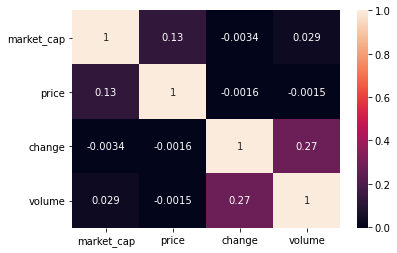

In [35]:
cor = df1.corr()
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, annot=True)

> It seems there is a little correlation between **Change** and **Volume**.

# Top movers

### Most traded stocks

In [36]:
df2 = df1.reset_index()

In [37]:
zsVol = zscore(df1.volume)
volumeOutliers = np.where(abs(zsVol) > 3)[0]
df2.loc[volumeOutliers].head(7)

,No.,ticker,company,sector,industry,country,market_cap,price,change,volume
67,77,ACST,Acasti Pharma Inc.,Healthcare,Biotechnology,Canada,215.40,1.20,22.45,140227255
243,286,AMC,"AMC Entertainment Holdings, Inc.",Communication Services,Entertainment,USA,2040.00,5.80,5.45,150761225
320,373,APHA,Aphria Inc.,Healthcare,Drug Manufacturers - Specialty & Generic,Canada,8330.00,26.30,10.74,116716639
1304,1582,CTRM,Castor Maritime Inc.,Industrials,Marine Shipping,Cyprus,605.13,1.19,12.26,265909658
2232,3035,GSAT,"Globalstar, Inc.",Communication Services,Telecom Services,USA,3770.00,2.40,15.38,306885205
2675,3717,ITRM,Iterum Therapeutics plc,Healthcare,Biotechnology,Ireland,126.04,2.73,20.26,137766583
3393,4700,NAK,Northern Dynasty Minerals Ltd.,Basic Materials,Other Industrial Metals & Mining,Canada,454.77,0.94,23.75,187948983


### Most percentage change

In [38]:
zsChng = zscore(df1.change)
changeOutliers = np.where(abs(zsChng) > 4)[0]
df2.loc[changeOutliers].head(7)

,No.,ticker,company,sector,industry,country,market_cap,price,change,volume
115,133,AESE,Allied Esports Entertainment Inc.,Communication Services,Entertainment,USA,116.41,3.12,31.65,9630636
287,335,ANCN,Anchiano Therapeutics Ltd.,Healthcare,Biotechnology,USA,59.06,7.96,184.29,45949039
328,381,APOP,Cellect Biotechnology Ltd.,Healthcare,Biotechnology,Israel,18.57,4.75,40.12,1657102
385,447,ARTL,"Artelo Biosciences, Inc.",Healthcare,Biotechnology,USA,30.08,1.82,26.39,25614123
464,534,AUVI,"Applied UV, Inc.",Consumer Cyclical,"Furnishings, Fixtures & Appliances",USA,109.73,14.65,-25.67,9663306
518,595,AYRO,"Ayro, Inc.",Consumer Cyclical,Auto Manufacturers,USA,349.18,11.49,50.20,44182294
751,897,BPTH,"Bio-Path Holdings, Inc.",Healthcare,Biotechnology,USA,54.02,11.77,126.35,95282895


### Most traded and most changed

In [39]:
bothOutliers = sorted(list(set(volumeOutliers).intersection(changeOutliers)))
df2.loc[bothOutliers].head(7)

,No.,ticker,company,sector,industry,country,market_cap,price,change,volume
3394,4701,NAKD,Naked Brand Group Limited,Consumer Cyclical,Apparel Manufacturing,New Zealand,649.76,1.52,33.33,430769590
3706,5056,OGI,OrganiGram Holdings Inc.,Healthcare,Drug Manufacturers - Specialty & Generic,Canada,1390.00,6.00,37.30,139115109
4591,6333,SNDL,Sundial Growers Inc.,Healthcare,Drug Manufacturers - Specialty & Generic,Canada,4650.00,2.95,78.79,2524457247
4931,6800,TLRY,"Tilray, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,Canada,8890.00,63.91,50.91,192488367
4977,6867,TRCH,"Torchlight Energy Resources, Inc.",Energy,Oil & Gas E&P,USA,269.08,2.60,62.19,275678787


# Group Analysis

In this section we take a look at DataFrame based on different groups:
- Sectors
- Country
- Industries

## Group Analysis: Sector

In [40]:
groupSector = df1.groupby('sector')

In [41]:
def showPartSector(Part):
    plt.figure(figsize=(27,10))
    colors = ['grey', 'red', 'green', 'orange', 'olive', 'gold', 'orchid', 'steelblue', 'mediumpurple', 'teal', 'pink']
    secs = [sec for sec in groupSector.ticker.count().index]
    
    if Part == 'Number of Companies':
        plt.subplot(1,2,1)
        plt.pie(groupSector.ticker.count(), labels=groupSector.ticker.count().index, autopct='%1.1f%%', colors=colors)
        plt.title("Sector comparison by:  Sector's total # of companies")
        
        plt.subplot(1,2,2)
        plt.bar(np.arange(len(groupSector.ticker.count())), groupSector.ticker.count(), color=colors)
        plt.xticks(np.arange(len(groupSector.ticker.count())), secs, rotation=90)
        plt.title("Sector comparison by:  Sector's total # of companies")
    
    elif Part == 'Volume':
        plt.subplot(1,2,1)
        plt.pie(groupSector.volume.sum(), labels=groupSector.volume.sum().index, autopct='%1.1f%%', colors=colors)
        plt.title("Sector comparison by:  Sector's total volume traded")
        
        plt.subplot(1,2,2)
        plt.bar(np.arange(len(groupSector.volume.sum())), groupSector.volume.sum(), color=colors)
        plt.xticks(np.arange(len(groupSector.volume.sum())), secs, rotation=90)
        plt.title("Sector comparison by:  Sector's total volume traded")

    elif Part == 'Market Cap':
        plt.subplot(1,2,1)
        plt.pie(groupSector.market_cap.sum(), labels=groupSector.market_cap.sum().index, autopct='%1.1f%%', colors=colors)
        plt.title("Sector comparison by:  Sector's total Market Cap")
        plt.subplot(1,2,2)
        plt.bar(np.arange(len(groupSector.market_cap.sum())), groupSector.market_cap.sum(), color=colors)
        plt.xticks(np.arange(len(groupSector.market_cap.sum())), secs, rotation=90)
        plt.title("Sector comparison by:  Sector's total Market Cap")

        
def showChartSector(Chart):
    plt.figure(figsize=(27,10))
    colors = ['grey', 'red', 'green', 'orange', 'olive', 'gold', 'orchid', 'steelblue', 'mediumpurple', 'teal', 'pink']
    secs = [sec for sec in groupSector.ticker.count().index]
    
    if Chart == 'Pie Chart':
        plt.subplot(1,3,1)
        plt.pie(groupSector.ticker.count(), labels=groupSector.ticker.count().index, autopct='%1.1f%%', colors=colors)
        plt.title("Sector comparison by:  Sector's total # of companies")

        plt.subplot(1,3,2)
        plt.pie(groupSector.volume.sum(), labels=groupSector.volume.sum().index, autopct='%1.1f%%', colors=colors)
        plt.title("Sector comparison by:  Sector's total volume traded")

        plt.subplot(1,3,3)
        plt.pie(groupSector.market_cap.sum(), labels=groupSector.market_cap.sum().index, autopct='%1.1f%%', colors=colors)
        plt.title("Sector comparison by:  Sector's total Market Cap")
    elif Chart == 'Bar Chart':
        plt.subplot(1,3,1)
        plt.bar(np.arange(len(groupSector.ticker.count())), groupSector.ticker.count(), color=colors)
        plt.xticks(np.arange(len(groupSector.ticker.count())), secs, rotation=90)
        plt.title("Sector comparison by:  Sector's total # of companies")

        plt.subplot(1,3,2)
        plt.bar(np.arange(len(groupSector.volume.sum())), groupSector.volume.sum(), color=colors)
        plt.xticks(np.arange(len(groupSector.volume.sum())), secs, rotation=90)
        plt.title("Sector comparison by:  Sector's total volume traded")

        plt.subplot(1,3,3)
        plt.bar(np.arange(len(groupSector.market_cap.sum())), groupSector.market_cap.sum(), color=colors)
        plt.xticks(np.arange(len(groupSector.market_cap.sum())), secs, rotation=90)
        plt.title("Sector comparison by:  Sector's total Market Cap")

In [42]:
prtSector = interactive(showPartSector, Part=['Number of Companies', 'Volume', 'Market Cap'])
crtSector = interactive(showChartSector, Chart=['Pie Chart', 'Bar Chart'])

tabSector = widgets.Tab()
tabSector.children = [prtSector, crtSector]
for i, item in enumerate(['By Part', 'By Chart']):
    tabSector.set_title(i, item)
tabSector

Major things to consider from these plots are:
- ***Basic Materials:*** # of companies and market cap are low BUT the volume traded is high.

- ***Financial:*** # of companies is really high and the market cap is considerable BUT volume traded is low.

- ***Healthcare:*** Most traded sector based on volume with large # of companies BUT the market cap is not high enough.

- ***Technology:*** It has the largest market cap with average # of comapnies AND good volume trading.

- ***Communication Services / Consumer Cyclical:*** Even though the # of companies is low BUT the market cap is high.

- ***Consumer Defensive / Energy / Industrials / Real Estate / Utilities:*** These are most likely the same in all three plots.

## Group Analysis: Country

In [43]:
groupCountry = df1.groupby('country')

Text(0.5, 1.0, "Country comparison by:  Country's total Market Cap")

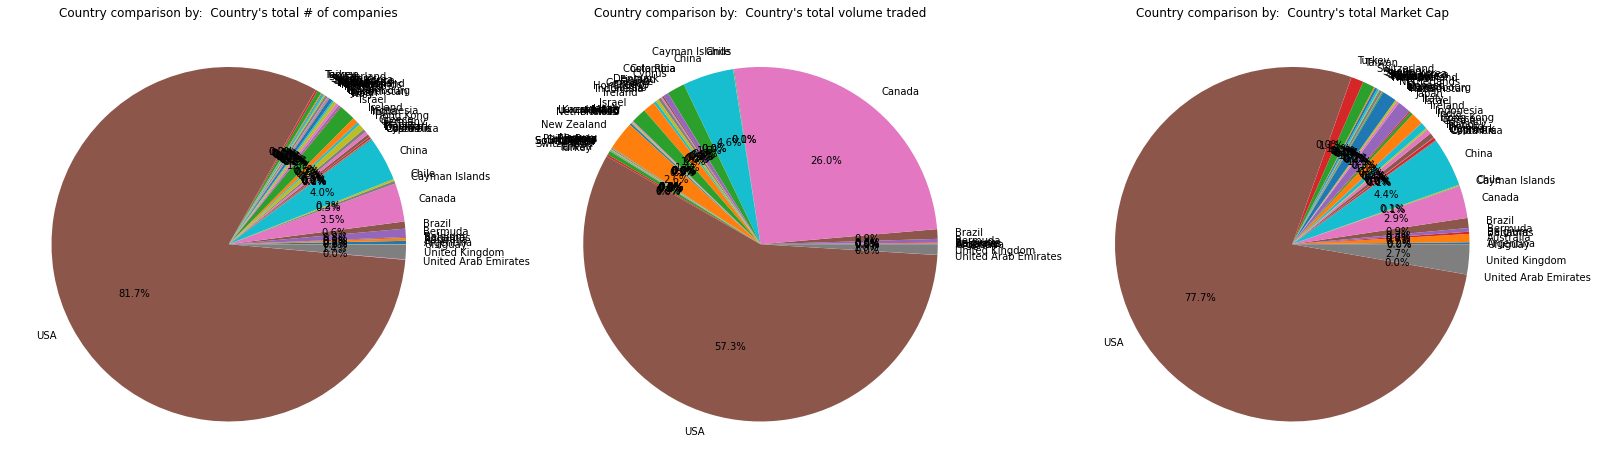

In [44]:
plt.figure(figsize=(27,10))

plt.subplot(1,3,1)
plt.pie(groupCountry.ticker.count(), labels=groupCountry.ticker.count().index, autopct='%1.1f%%')
plt.title("Country comparison by:  Country's total # of companies")

plt.subplot(1,3,2)
plt.pie(groupCountry.volume.sum(), labels=groupCountry.volume.sum().index, autopct='%1.1f%%')
plt.title("Country comparison by:  Country's total volume traded")

plt.subplot(1,3,3)
plt.pie(groupCountry.market_cap.sum(), labels=groupCountry.market_cap.sum().index, autopct='%1.1f%%')
plt.title("Country comparison by:  Country's total Market Cap")

It's obvious that USA dominate the market. The leading countries are: USA, Canada, China

To get a better intuition, It's recommended to look at the data by region. To do so, we're going to add a column Region.

### Group Analysis: Region
> Since the major countries in the market are USA, Canda, and China, we separate these countries from other regions.

In [45]:
def findRegion(row):
    Regions = {
    'America': ['Uruguay', 'Peru', 'Panama', 'Mexico', 'Costa Rica', 'Colombia', 'Chile', 'Brazil', 'Bahamas', 'Argentina'],
    'Europe': ['Belgium', 'Bermuda', 'Cayman Islands', 'Cyprus', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Malta', 'Monaco', 'Netherlands', 'Norway', 'Russia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom'],
    'Asia': ['Taiwan', 'South Korea', 'Singapore', 'Philippines', 'Kazakhstan', 'Japan', 'Indonesia', 'India', 'Hong Kong', 'Israel', 'United Arab Emirates'],
    'Other' : ['Australia', 'New Zealand', 'South Africa'],
    'USA': ['USA'],
    'Canada': ['Canada'],
    'China': ['China'],
}
    for region in Regions:
        if row['country'] in Regions[region]:
            return region

df1['region'] = df1.apply(findRegion, axis='columns')

In [46]:
groupRegion = df1.groupby('region')

In [47]:
def showPartRegion(Part):
    plt.figure(figsize=(27,10))
    colors = ['grey', 'red', 'green', 'orange', 'olive', 'gold', 'orchid', 'steelblue', 'mediumpurple', 'teal', 'pink']
    regs = [reg for reg in groupRegion.ticker.count().index]
    
    if Part == 'Number of Companies':
        plt.subplot(1,2,1)
        plt.pie(groupRegion.ticker.count(), labels=groupRegion.ticker.count().index, autopct='%1.1f%%')
        plt.title("Region comparison by:  Region's total # of companies")
        
        plt.subplot(1,2,2)
        plt.bar(np.arange(len(groupRegion.ticker.count())), groupRegion.ticker.count(), color=colors)
        plt.xticks(np.arange(len(groupRegion.ticker.count())), regs, rotation=90)
        plt.title("Region comparison by:  Region's total # of companies")
    
    elif Part == 'Volume':
        plt.subplot(1,2,1)
        plt.pie(groupRegion.volume.sum(), labels=groupRegion.volume.sum().index, autopct='%1.1f%%')
        plt.title("Region comparison by:  Region's total volume traded")
        
        plt.subplot(1,2,2)
        plt.bar(np.arange(len(groupRegion.volume.sum())), groupRegion.volume.sum(), color=colors)
        plt.xticks(np.arange(len(groupRegion.volume.sum())), regs, rotation=90)
        plt.title("Region comparison by:  Region's total volume traded")

    elif Part == 'Market Cap':
        plt.subplot(1,2,1)
        plt.pie(groupRegion.market_cap.sum(), labels=groupRegion.market_cap.sum().index, autopct='%1.1f%%')
        plt.title("Region comparison by:  Region's total Market Cap")
        plt.subplot(1,2,2)
        plt.bar(np.arange(len(groupRegion.market_cap.sum())), groupRegion.market_cap.sum(), color=colors)
        plt.xticks(np.arange(len(groupRegion.market_cap.sum())), regs, rotation=90)
        plt.title("Region comparison by:  Region's total Market Cap")
        
def showChartRegion(Chart):
    plt.figure(figsize=(27,10))
    colors = ['grey', 'red', 'green', 'orange', 'olive', 'gold', 'orchid', 'steelblue', 'mediumpurple', 'teal', 'pink']
    regs = [reg for reg in groupRegion.ticker.count().index]
    
    if Chart == 'Pie Chart':
        plt.subplot(1,3,1)
        plt.pie(groupRegion.ticker.count(), labels=groupRegion.ticker.count().index, autopct='%1.1f%%')
        plt.title("Region comparison by:  Region's total # of companies")

        plt.subplot(1,3,2)
        plt.pie(groupRegion.volume.sum(), labels=groupRegion.volume.sum().index, autopct='%1.1f%%')
        plt.title("Region comparison by:  Region's total volume traded")

        plt.subplot(1,3,3)
        plt.pie(groupRegion.market_cap.sum(), labels=groupRegion.market_cap.sum().index, autopct='%1.1f%%')
        plt.title("Region comparison by:  Region's total Market Cap")
    elif Chart == 'Bar Chart':
        plt.subplot(1,3,1)
        plt.bar(np.arange(len(groupRegion.ticker.count())), groupRegion.ticker.count(), color=colors)
        plt.xticks(np.arange(len(groupRegion.ticker.count())), regs, rotation=90)
        plt.title("Region comparison by:  Region's total # of companies")

        plt.subplot(1,3,2)
        plt.bar(np.arange(len(groupRegion.volume.sum())), groupRegion.volume.sum(), color=colors)
        plt.xticks(np.arange(len(groupRegion.volume.sum())), regs, rotation=90)
        plt.title("Region comparison by:  Region's total volume traded")

        plt.subplot(1,3,3)
        plt.bar(np.arange(len(groupRegion.market_cap.sum())), groupRegion.market_cap.sum(), color=colors)
        plt.xticks(np.arange(len(groupRegion.market_cap.sum())), regs, rotation=90)
        plt.title("Region comparison by:  Region's total Market Cap")

In [48]:
prtRegion = interactive(showPartRegion, Part=['Number of Companies', 'Volume', 'Market Cap'])
crtRegion = interactive(showChartRegion, Chart=['Pie Chart', 'Bar Chart'])

tabRegion = widgets.Tab()
tabRegion.children = [prtRegion, crtRegion]
for i, item in enumerate(['By Part', 'By Chart']):
    tabRegion.set_title(i, item)
tabRegion

Major things to consider from these plots are:
- Still ***USA*** dominate the market.
- Even tough ***Canadian*** companies traded with high volume, their market cap is not much.
- ***Europe*** and ***China*** act similar to each other but Europe has stronger impact both in volume and market cap.

## Group Analysis: Industry

In [49]:
groupIndustry = df1.groupby(['sector', 'industry'])

Text(0.5, 1.3, 'Industry comparison grouprd by Sectors: total Market Cap')

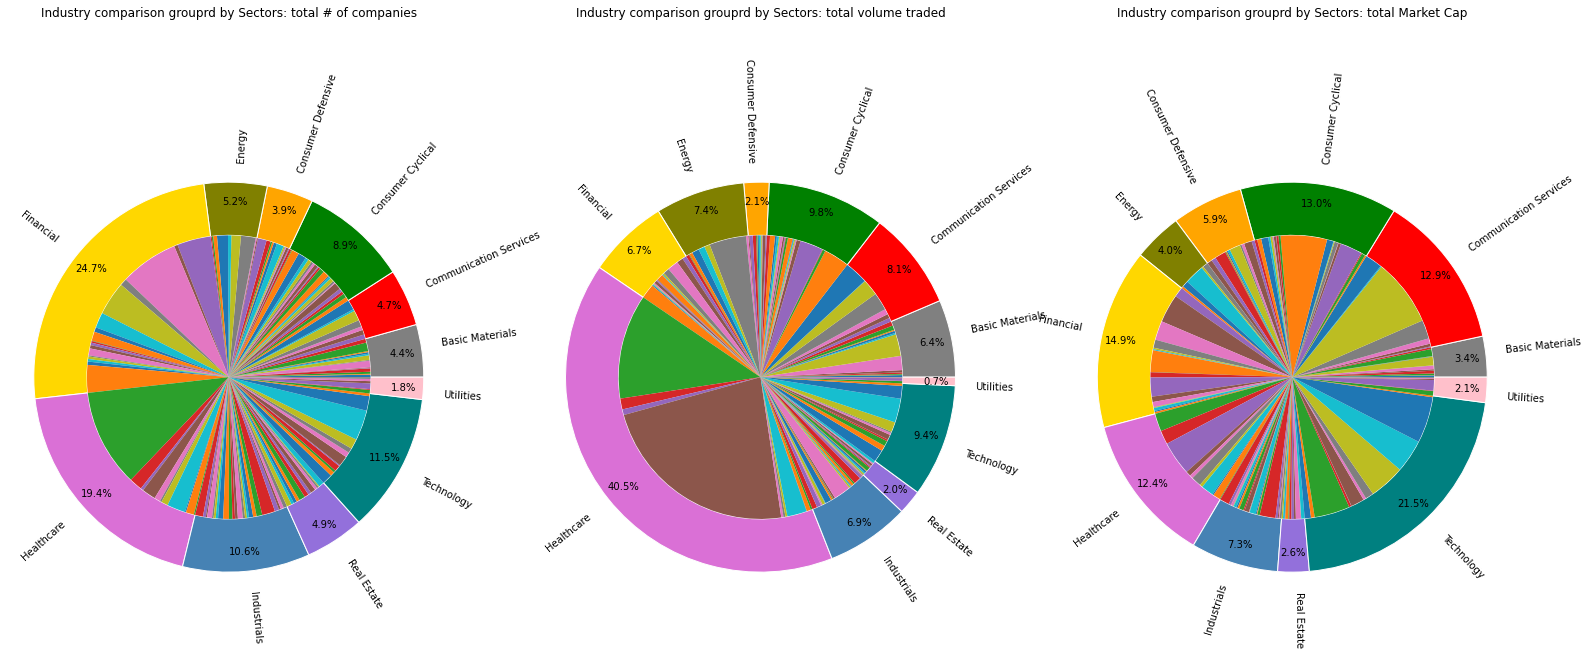

In [50]:
plt.figure(figsize=(27,10))
colors = ['grey', 'red', 'green', 'orange', 'olive', 'gold', 'orchid', 'steelblue', 'mediumpurple', 'teal', 'pink']

plt.subplot(1,3,1)
plt.pie(groupSector.ticker.count(), labels=groupSector.ticker.count().index, colors=colors, wedgeprops=dict(width=0.3, edgecolor='w'), radius=1.1, autopct='%1.1f%%', pctdistance=0.9, rotatelabels=True)
plt.pie(groupIndustry.ticker.count(), radius=0.8)
plt.title("Industry comparison grouprd by Sectors: total # of companies", y=1.3)

plt.subplot(1,3,2)
plt.pie(groupSector.volume.sum(), labels=groupSector.volume.sum().index, colors=colors, wedgeprops=dict(width=0.3, edgecolor='w'), radius=1.1, autopct='%1.1f%%', pctdistance=0.9, rotatelabels=True)
plt.pie(groupIndustry.volume.sum(), radius=0.8)
plt.title("Industry comparison grouprd by Sectors: total volume traded", y=1.3)

plt.subplot(1,3,3)
plt.pie(groupSector.market_cap.sum(), labels=groupSector.market_cap.sum().index, colors=colors, wedgeprops=dict(width=0.3, edgecolor='w'), radius=1.1, autopct='%1.1f%%', pctdistance=0.9, rotatelabels=True)
plt.pie(groupIndustry.market_cap.sum(), radius=0.8)
plt.title("Industry comparison grouprd by Sectors: total Market Cap", y=1.3)

- Industries with considerable number of companies:
    - Couple of industries in Financial sector
    - One industry in Technology sector
    - One industry in Healthcare sector

- Industries with considerable volume traded:
    - Two major industries in Healthcare sector
    - Two major industries in Consumer Cyclical sector
    - One industry in Technology sector
    - One industry in Basic Materails sector
    - Three major industries in Communication Services sector
    - One industry in Industrials sector

- Industries with considerable market cap: 
    - Couple of industries in Technology sector
    - One industry in Communication Services sector
    - One industry in Consumer Cyclical sector
    - One industry in Healthcare sector
---
### Let's look at the industries in each sector for more intuition.

In [51]:
def industryTabCreator(sect):
    
    def showPartIndustry(Part):
        colorsIndustry = sns.color_palette('muted', n_colors=25)
        secs = [sec for sec in groupSector.ticker.count().index]
        plt.figure(figsize=(27,10))

        if Part == 'Number of Companies':
            plt.subplot(1,2,1)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.pie(groupSector.get_group(sect).groupby('industry').ticker.count(), labels=groupSector.get_group(sect).groupby('industry').ticker.count().index, autopct='%1.1f%%', rotatelabels=True, colors=colorsIndustry)

            plt.subplot(1,2,2)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.bar(np.arange(len(groupSector.get_group(sect).groupby('industry').ticker.count())), groupSector.get_group(sect).groupby('industry').ticker.count(), color=colorsIndustry)
            plt.xticks(np.arange(len(groupSector.get_group(sect).groupby('industry').ticker.count())), groupSector.get_group(sect).groupby('industry').ticker.count().index, rotation=90)

        elif Part == 'Volume':
            plt.subplot(1,2,1)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.pie(groupSector.get_group(sect).groupby('industry').volume.sum(), labels=groupSector.get_group(sect).groupby('industry').volume.sum().index, autopct='%1.1f%%', rotatelabels=True, colors=colorsIndustry)

            plt.subplot(1,2,2)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.bar(np.arange(len(groupSector.get_group(sect).groupby('industry').volume.sum())) , groupSector.get_group(sect).groupby('industry').volume.sum(), color=colorsIndustry)
            plt.xticks(np.arange(len(groupSector.get_group(sect).groupby('industry').volume.sum())) , groupSector.get_group(sect).groupby('industry').volume.sum().index, rotation=90)

        elif Part == 'Market Cap':
            plt.subplot(1,2,1)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.pie(groupSector.get_group(sect).groupby('industry').market_cap.sum(), labels=groupSector.get_group(sect).groupby('industry').market_cap.sum().index, autopct='%1.1f%%', rotatelabels=True, colors=colorsIndustry)

            plt.subplot(1,2,2)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.bar(np.arange(len(groupSector.get_group(sect).groupby('industry').market_cap.sum())), groupSector.get_group(sect).groupby('industry').market_cap.sum(), color=colorsIndustry)
            plt.xticks(np.arange(len(groupSector.get_group(sect).groupby('industry').market_cap.sum())), groupSector.get_group(sect).groupby('industry').market_cap.sum().index, rotation=90)

    def showChartIndustry(Chart):
        colorsIndustry = sns.color_palette('muted', n_colors=25)
        secs = [sec for sec in groupSector.ticker.count().index]
        plt.figure(figsize=(27,10))

        if Chart == 'Pie Chart':      
            plt.subplot(1,3,1)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.pie(groupSector.get_group(sect).groupby('industry').ticker.count(), labels=groupSector.get_group(sect).groupby('industry').ticker.count().index, autopct='%1.1f%%', rotatelabels=True, colors=colorsIndustry)

            plt.subplot(1,3,2)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.pie(groupSector.get_group(sect).groupby('industry').volume.sum(), labels=groupSector.get_group(sect).groupby('industry').volume.sum().index, autopct='%1.1f%%', rotatelabels=True, colors=colorsIndustry)

            plt.subplot(1,3,3)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.pie(groupSector.get_group(sect).groupby('industry').market_cap.sum(), labels=groupSector.get_group(sect).groupby('industry').market_cap.sum().index, autopct='%1.1f%%', rotatelabels=True, colors=colorsIndustry)



        elif Chart == 'Bar Chart':
            plt.subplot(1,3,1)
            plt.title(f'Industry comparison in sector " {sect} ": total # of companies')
            plt.bar(np.arange(len(groupSector.get_group(sect).groupby('industry').ticker.count())), groupSector.get_group(sect).groupby('industry').ticker.count(), color=colorsIndustry)
            plt.xticks(np.arange(len(groupSector.get_group(sect).groupby('industry').ticker.count())), groupSector.get_group(sect).groupby('industry').ticker.count().index, rotation=90)

            plt.subplot(1,3,2)
            plt.title(f'Industry comparison in sector " {sect} ": total volume traded')
            plt.bar(np.arange(len(groupSector.get_group(sect).groupby('industry').volume.sum())) , groupSector.get_group(sect).groupby('industry').volume.sum(), color=colorsIndustry)
            plt.xticks(np.arange(len(groupSector.get_group(sect).groupby('industry').volume.sum())) , groupSector.get_group(sect).groupby('industry').volume.sum().index, rotation=90)

            plt.subplot(1,3,3)
            plt.title(f'Industry comparison in sector " {sect} ": total Market Cap')
            plt.bar(np.arange(len(groupSector.get_group(sect).groupby('industry').market_cap.sum())), groupSector.get_group(sect).groupby('industry').market_cap.sum(), color=colorsIndustry)
            plt.xticks(np.arange(len(groupSector.get_group(sect).groupby('industry').market_cap.sum())), groupSector.get_group(sect).groupby('industry').market_cap.sum().index, rotation=90)
        
        
    prtInd = interactive(showPartIndustry, Part=['Number of Companies', 'Volume', 'Market Cap'])
    crtInd = interactive(showChartIndustry, Chart=['Pie Chart', 'Bar Chart'])

    tabIndustry = widgets.Tab()
    tabIndustry.children = [prtInd, crtInd]
    for i, item in enumerate(['By Part', 'By Chart']):
        tabIndustry.set_title(i, item)
    return tabIndustry

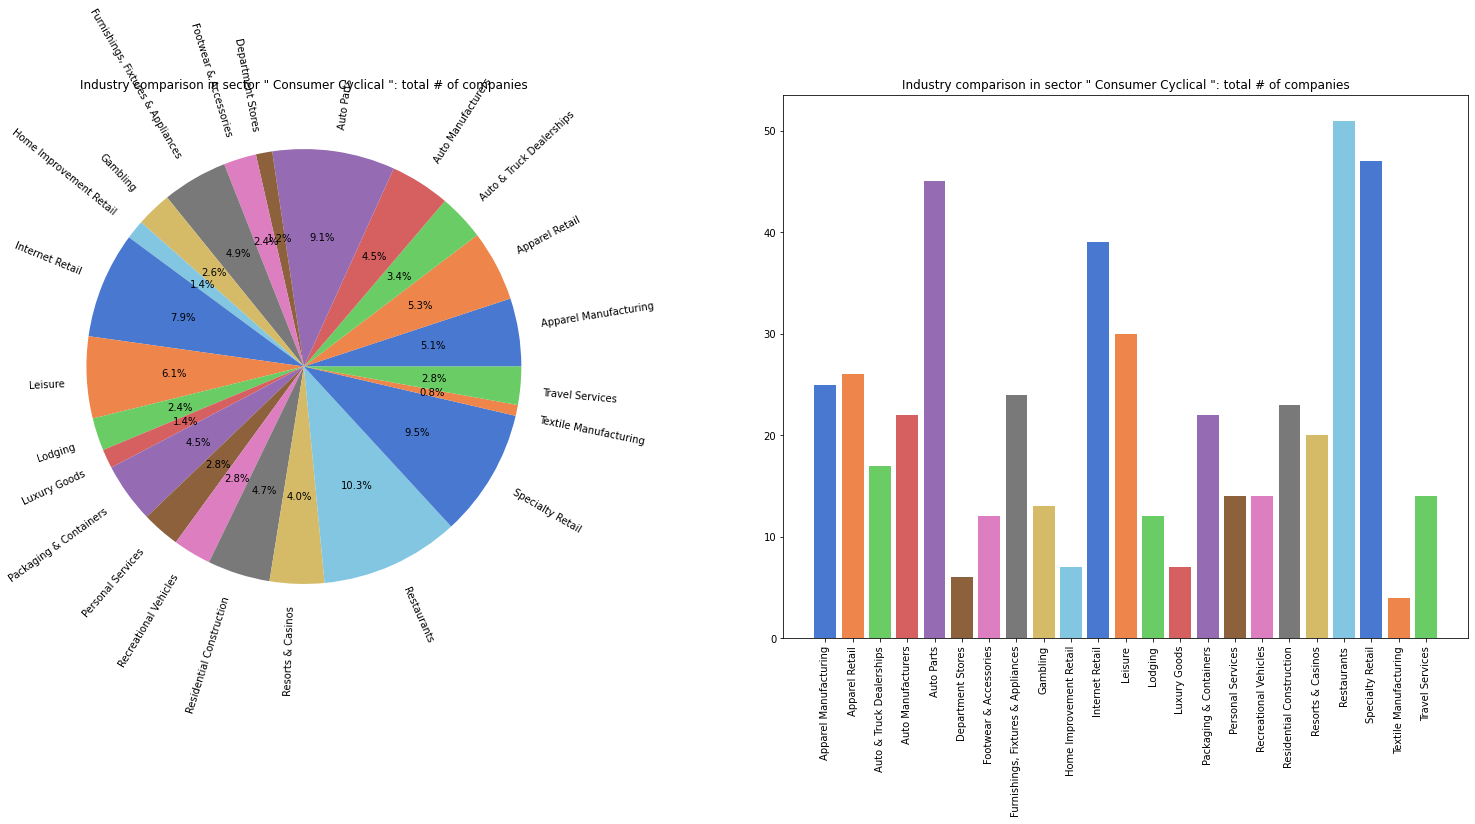

In [52]:
secs = [sec for sec in groupSector.ticker.count().index]
accordion = widgets.Accordion(children=[industryTabCreator(sec) for sec in secs])
for i in range(11):
    accordion.set_title(i, secs[i])
accordion

---

# ETF (Exchange Traded Fund)

In [53]:
# Extracting ETFs from original DataFrame for further usage
ETFs = df[df.industry == 'Exchange Traded Fund'].reset_index()
ETFs.drop(['No.'], axis=1, inplace=True)
ETFs.drop(['p/e', 'market_cap', 'country', 'industry', 'sector'], axis=1, inplace=True)

## ETF DataFrame after cleaning

In [54]:
ETFs.head(7)

,ticker,company,price,change,volume
0,AAAU,Goldman Sachs Physical Gold ETF,18.34,0.38,792392
1,AADR,AdvisorShares Dorsey Wright ADR ETF,66.03,0.27,1053
2,AAXJ,iShares MSCI All Country Asia ex Japan ETF,100.37,0.29,1380252
3,ABEQ,Absolute Core Strategy ETF,26.04,-0.36,876
4,ACES,ALPS Clean Energy ETF,98.43,-1.88,156274
5,ACIO,Aptus Collared Income Opportunity ETF,27.90,-0.14,54705
6,ACWF,iShares MSCI Global Multifactor ETF,35.58,-0.17,22241


## Intuition

We need to look at the data and it's descriptive measurements to have some insight with the data we're dealing with.

In [55]:
ETFs.describe()

,price,change,volume
count,1990.000000,1990.000000,1.990000e+03
mean,57.503482,0.065834,8.155401e+05
std,56.977131,1.270388,4.891415e+06
min,1.940000,-6.870000,0.000000e+00
25%,26.972500,-0.220000,7.787750e+03
50%,39.270000,0.000000,3.644300e+04
75%,65.797500,0.210000,2.359960e+05
max,599.950000,22.770000,1.260699e+08


### Let's take a look at correlation matrix:

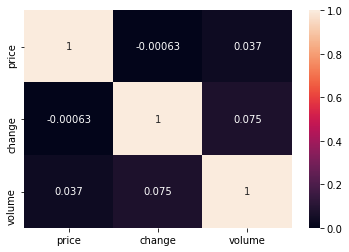

In [56]:
corETF = ETFs.corr()
sns.heatmap(corETF, xticklabels=corETF.columns, yticklabels=corETF.columns, annot=True)

> No significant correlation found.

## Top movers

### Most traded ETFs

In [57]:
zsVolETF = zscore(ETFs.volume)
volumeOutliersETF = np.where(abs(zsVolETF) > 3)[0]
ETFs.loc[volumeOutliersETF].head(7)

,ticker,company,price,change,volume
374,EEM,iShares MSCI Emerging Markets ETF,57.14,0.35,30529190
482,EWZ,iShares MSCI Brazil ETF,35.70,-0.86,20744044
795,HYG,iShares iBoxx $ High Yield Corporate Bond ETF,87.60,-0.02,20421547
811,IAU,iShares Gold Trust,17.57,0.46,16764093
974,IWM,iShares Russell 2000 ETF,226.88,-0.66,27830921
1157,MJ,ETFMG Alternative Harvest ETF,33.21,14.91,17674456
1403,QQQ,Invesco QQQ Trust,332.75,-0.23,27805764


### Most percentage change

In [58]:
zsChngETF = zscore(ETFs.change)
changeOutliersETF = np.where(abs(zsChngETF) > 4)[0]
ETFs.loc[changeOutliersETF].head(7)

,ticker,company,price,change,volume
84,BDRY,Breakwave Dry Bulk Shipping ETF,10.75,6.44,83668
107,BLOK,Amplify Transformational Data Sharing ETF,49.56,-5.90,2107531
120,BOIL,ProShares Ultra Bloomberg Natural Gas,27.36,7.21,1577271
207,CNBS,Amplify Seymour Cannabis ETF,39.90,14.66,1209287
751,GXTG,Global X Thematic Growth ETF,65.27,7.49,129142
1089,KOLD,ProShares UltraShort Bloomberg Natural Gas,32.10,-6.79,1675742
1103,LABD,Direxion Daily S&P Biotech Bear 3X Shares,13.79,6.65,5795634


### Most traded and most changed

In [59]:
bothOutliersETF = sorted(list(set(volumeOutliersETF).intersection(changeOutliersETF)))
ETFs.loc[bothOutliersETF].head(7)

,ticker,company,price,change,volume
1157,MJ,ETFMG Alternative Harvest ETF,33.21,14.91,17674456
